In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import geopy.geocoders
from geopy.geocoders import Nominatim, GoogleV3
from sklearn.linear_model import LinearRegression
import numpy as np
import re
import config
from geopy import distance

%matplotlib inline
pd.set_option('display.max_colwidth', -1) #setting used to display the full links properly

In [2]:
#instantiate geocoder
geolocator = Nominatim(user_agent='my_app/1')
geolocator_google = GoogleV3(api_key=config.gmaps_api_key)

## Read file and clean variables

In [3]:
#read csv
df = pd.read_csv('all_listings_9Apr20.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24158 entries, 0 to 24157
Data columns (total 13 columns):
address          24158 non-null object
amenities        18563 non-null object
area             24158 non-null object
bathrooms        22819 non-null float64
bedrooms         22819 non-null object
description      23517 non-null object
details          23576 non-null object
lease            24158 non-null object
link             24158 non-null object
name             24158 non-null object
price            24157 non-null object
property_type    22950 non-null object
psf_price        24158 non-null object
dtypes: float64(1), object(12)
memory usage: 2.4+ MB


In [4]:
df.head()

address  \
0  12 Dairy Farm Lane - D23   
1  2 Shunfu Road - D20        
2  21 Marina Way - D1         
3  3 Jalan Kemaman - D12      
4  5 Jalan Kemaman - D12      

                                                                                                                                                                                                                                                                                                                       amenities  \
0  Function Room,Water Feature,High Ceiling,Gym,Jet Pool,Yoga Corner,Tennis Court,Mid Floor,Undrewater Fitness Station,Outdoor Dining,Balcony,City View,Pool View,Renovated,Hammocks,Lap Pool,Greenery View,Pool Deck,Lounge,Wading Pool,Fountain,Playground,Fitness Corner,High Floor,Security,Fibre Ready,Reflexology Path,BBQ   
1  Jogging Track,Games Room,Gym,Sea View,Steam Room,Tennis Court,Pond,Karaoke,Balcony,Infinity Pool,Pavilion,Greenery View,Lounge,Swimming Pool,Waterfall,Playground,Fibre Ready,Reflexology Path                                                                                                                                  
2  Clubhouse,Gym,City View,Jacuzzi,Outdoor Dining,Balcony,Multi-purpose Hall,Bomb Shelter,Pavilion,Greenery View,Pool Deck,Lounge,Mini Golf Range,Wading Pool,Hydrotherapy Pool,Fitness Corner,High Floor,Fibre Ready,Lap Pool,BBQ                                                                                                 
3  Clubhouse,Pool Deck,Sky Lounge,Gym,Tennis Court,Parking,Undrewater Fitness Station,Outdoor Dining,Sky Terrace,Balcony,Bomb Shelter,Pavilion,Greenery View,Open Terrace,Swimming Pool,Spa Pool,Playground,Fitness Corner,High Floor,Security,Fibre Ready,Lap Pool,BBQ                                                            
4  Clubhouse,Bomb Shelter,Greenery View,Swimming Pool,Wading Pool,Squash Court,Parking,High Floor,Security,Fibre Ready,Gym,Balcony                                                                                                                                                                                                 

                   area  bathrooms bedrooms  \
0  624 sqft / 57.97 sqm  2.0        2         
1  764 sqft / 70.97 sqm NaN         NaN       
2  710 sqft / 65.96 sqm  2.0        1         
3  441 sqft / 40.97 sqm  1.0        1         
4  635 sqft / 58.99 sqm  1.0        2         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [5]:
# web scraping might have pulled duplicates if the same property is listed in multiple categories.
# drop duplicates. 
# if combining data pulled at different times, prices might have changed - in that case, drop duplicates based on link instead and only take the latest pulled data.
df = df.drop_duplicates(keep='first')
# df.loc[:,'listing_id'] = df['link'].apply(lambda x: x[x.rfind('-')+1:]) # this line extracts the listing id from the link. 

In [6]:
# price is in string format containing $ and ,.
# convert price to numeric
df.loc[:,'price'] = pd.to_numeric(df['price'].str.replace('$','').str.replace(',',''),errors='coerce')

# convert psf_price to numeric
df.loc[:,'psf_price'] = df['psf_price'].str.findall('([0-9]+)').str.join('').astype(int) 
# df.loc[:,'psf_price'] = df['psf_price'].str.replace('$','').str.replace(',','').str.replace(' psf','').astype(int)] #alternative method

# convert area to numeric in sqft
df['area'] = df['area'].map(lambda x: int(x.split(' / ')[0].replace(',','').replace(' sqft','')))

In [7]:
# bedrooms are not numeric for some reason.
df.bedrooms.unique()

array(['2', nan, '1', '3', '9', '4', '5', '6', '7', '8', '0', '10', ' '],
      dtype=object)

In [8]:
# it's because bedroom data has string containing whitespace ' '. 
df[df.bedrooms==' ']

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price
4255,Ernani Street - D15,NaN,1600,5.0,,TOP Q1 2020,"Availability,Now,Tenancy Current Rent,S$0,Cost of Renovation,S$0,District,D15",1980 - Freehold,https://www.99.co/singapore/sale/property/ernani-street-landed-LopPwsZfrJp2fSaRhz3cF4,Opera Estate,3800000.0,Terraced House,2375
4257,Watten Estate Road - D11,NaN,4600,5.0,,"Come Immerse the Peaceful Vibes and Tranquility in this Charming House today!\nFreehold ! District 11, this Elevated 3 storeys Corner Link-Bungalow House, it is nestled in an exclusive neighborhood with Panoramic greenery view, 100% Privacy, Tranquil and Calming feel. Immaculate Tip Top Condition! \n\nArrange a viewing now and make this your dream home today, True Gem! \n* Freehold, 3 Storeys Link Bungalow \n* Land size:Approx 4600qft, built in: 5000sqft\n* 7 Bedrooms (1 Guest room on 1st floor, 6 bedrooms and 1 maid room)\n* Big garden, Extra Wide Frontage \n* No Noon Sun, Renovated\n* Park 3-4 cars, WOW!\n* Within 1-2 KM to Nanyang Primary school, RGPS\n* Bright & Breezy\n* 10 mins walk to Main Road, Tan Kah Kee MRT.","Availability,Now,Tenancy Current Rent,S$0,Cost of Renovation,S$0,District,D11",- Freehold,https://www.99.co/singapore/sale/property/watten-estate-road-landed-GhnkWajjchUbKVs2nxjvJK,Watten Estate,8900000.0,Bungalow,1935
4258,Watten Close - D11,NaN,1800,2.0,,"New Listing! Highly Sought after location! Don’t miss again!\nDistrict 11 Watten vicinity Intermediate House, Freehold, Elevated 2 Storeys, 4 Bedrooms with a garden, move in condition, serene neighborhood, Private & tranquil! see to appreciate! Serious seller! \nMins to city and near amenities, Coronation S.C, Cluny court, Adam food centre, Greenwoods Bistros & Restaurants. Surround by good schools, RGPS, Nanyang Primary, MGS, etc.\nAlmost sold! View now!Suit A&A or rebuilt. Sell with vacant possession, Key on hand!\n \n*Arrange an exclusive viewing today with Joyce 9008 4000","Availability,Now,Tenancy Current Rent,S$0,Cost of Renovation,S$0,District,D11",- Freehold,https://www.99.co/singapore/sale/property/watten-close-landed-YKjUPiPMRHsHK4pBxi2GfP,Watten Estate,4500000.0,Terraced House,2500
4261,Jalan Dermawan - D23,NaN,8450,3.0,,"Design your own house or Owner design for You!\nFreehold Exclusive Cul De Sac 2 Storeys Corner Hilltop House with Goodsized Garden space for you to realize its full Potential. Exclusively Located with Full Privacy, stonethrow to nearby cafes, bars and convenience stores. Come and visit this Auspicious Number today, \nCall me Joyce Lau 9008 4000 for an Personal Viewing today.\nLand approx 8500ft, Built up 4000ft.\n\nSituated in a quiet residential area, Hillview Garden Estate is surrounded by private condonimums and landed houses. It is near parks like Bukit Batok Nature Park and Bukit Timah Nature Reserve, Dairy Farm Nature Park, Chestnut Nature Park and Rifle Range Nature Park\n\nThe closest shopping malls are HillV2, THE RAIL MALL, and West Mall with the nearest train stations such as Hillview MRT (DT3), Bukit Gombak (NS3), and Cashew MRT (DT2).\n\nThe nearest primary schools are Lianhua Primary School, Chij Our Lady Queen Of Peace, and Dazhong Primary School.","Availability,Now,Tenancy Current Rent,S$0,Cost of Renovation,S$0,District,D23",- Freehold,https://www.99.co/singapore/sale/property/jalan-dermawan-landed-yf77KAzUtcz8mgVL6VZmEB,Hillview Garden Estate,7400000.0,Semi-Detached House,876
4345,Jalan Lakum - D28,NaN,3800,7.0,,Swimming pool. Lift. Equipped with full solar panels. Top soon.,"Availability,Now,Tenancy Current Rent,S$0,Cost of Renovation,S$0,District,D28",2013 - Freehold,https://www.99.co/singapore/sale/property/jalan-lakum-landed-BNhN8GLQNbQakifZRJcHub,Seletar Hills Estate,5950000.0,Terraced House,1566
4346,Jalan Emas Urai - D23,"Jacuzzi,Lap Pool",3821,4.0,,"Rare 3 storey Cluster House with Basement & Roof terrace.\n\nLocated in a Transquil n Greenery environment.\n\nCorner Unit with privac

In [9]:
# these rows have number of bathroom data filled, which is a good proxy for the value of number of bedrooms
df.loc[df.bedrooms==' ','bedrooms'] = df[df.bedrooms==' ']['bathrooms']
df.loc[:,'bedrooms'] = pd.to_numeric(df['bedrooms'])

In [10]:
# some property_type is na. some of this information can be inferred from the link (99.co....<landed>.... or 99.co...<hdb>...)
df.loc[(df.property_type.isna())&(df.link.str.contains('landed')),'property_type'] = 'Landed'
df.loc[(df.property_type.isna())&(df.link.str.contains('hdb')),'property_type'] = 'HDB'
df.loc[(df.property_type.isna())&(df.link.str.contains('condo')),'property_type'] = 'Condo'

## EDA

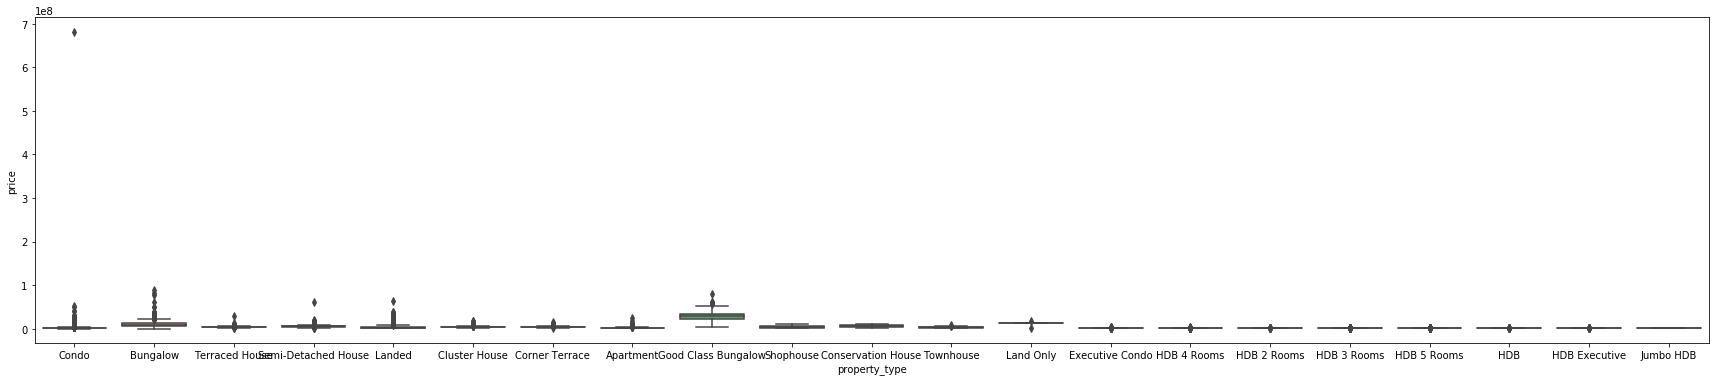

In [11]:
# EDA on price data
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='property_type', y='price')

In [12]:
# there is an outlier at over $600mil
# remove outlier
df = df[df.price<5e8]

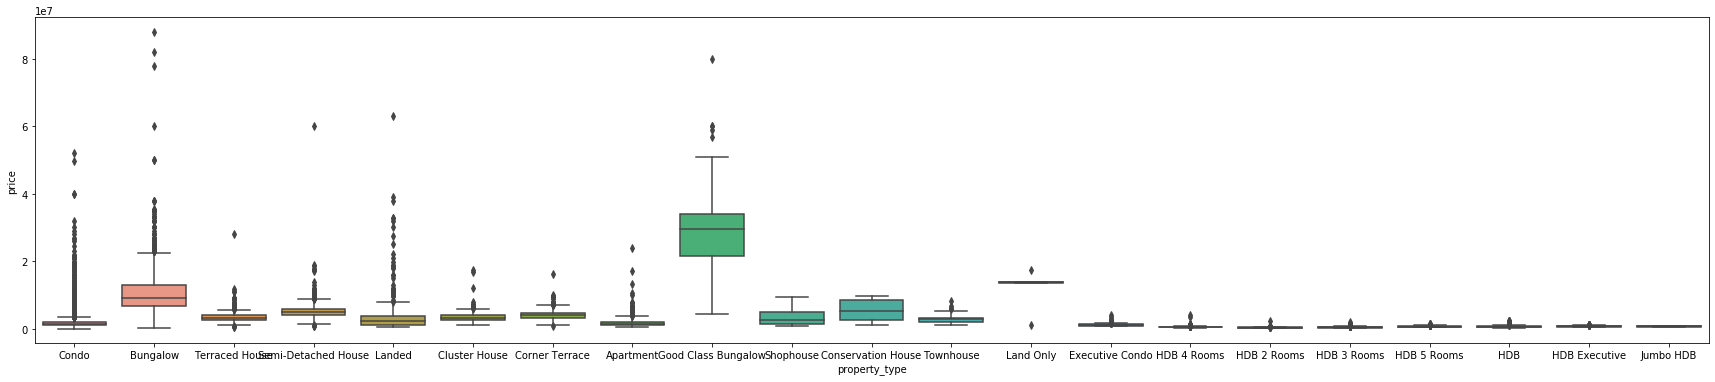

In [13]:
### EDA based on property type
# box plot
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='property_type', y='price')

In [14]:
### EDA based on property type
# summary price stats
df.groupby('property_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Apartment,349.0,2.045329e+06,2.158176e+06,480000.0,1000000.0,1380000.0,2068000.0,24000000.0
Bungalow,1456.0,1.103977e+07,6.997294e+06,100000.0,6800000.0,9100000.0,13007015.0,88000000.0
Cluster House,522.0,3.261654e+06,1.386101e+06,1190000.0,2482500.0,3032000.0,3880000.0,17439488.0
Condo,7532.0,1.912430e+06,2.260570e+06,0.0,985750.0,1380000.0,1980000.0,52217000.0
Conservation House,22.0,5.576273e+06,3.127837e+06,949999.0,2680000.0,5175000.0,8500000.0,9800000.0
Corner Terrace,861.0,4.049343e+06,1.316525e+06,700000.0,3200000.0,3900000.0,4690000.0,16130000.0
Executive Condo,804.0,1.081893e+06,2.831442e+05,700000.0,899075.0,998000.0,1210000.0,3980000.0
Good Class Bungalow,127.0,2.911844e+07,1.167995e+07,4188000.0,21500000.0,29600000.0,33900000.0,80000000.0
HDB,725.0,5.314612e+05,2.446089e+05,218000.0,370000.0,490000.0,620000.0,2200000.0


In [15]:
### baseline prediction of regression model
# using mean price by property type
# the baseline RMSE is calculated from the property price compared to the mean price of its property type - calculation is equivalent to std dev with ddof=0
def baseline_rmse(x):
    return x.std(ddof=0)
df.groupby('property_type')['price'].agg(['mean',baseline_rmse])

,mean,baseline_rmse
property_type,,
Apartment,2.045329e+06,2.155081e+06
Bungalow,1.103977e+07,6.994890e+06
Cluster House,3.261654e+06,1.384772e+06
Condo,1.912430e+06,2.260420e+06
Conservation House,5.576273e+06,3.055923e+06
Corner Terrace,4.049343e+06,1.315760e+06
Executive Condo,1.081893e+06,2.829680e+05
Good Class Bungalow,2.911844e+07,1.163388e+07
HDB,5.314612e+05,2.444401e+05


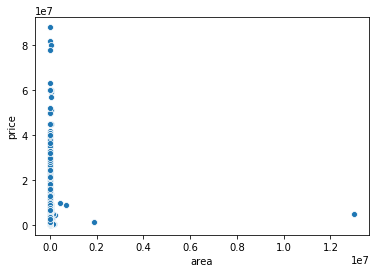

In [16]:
sns.scatterplot(data=df,x='area',y='price')

In [17]:
# there are outliers for area information, which have been wrongly entered by the property agent. 
df[df.area>10000]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price
15,Jalan Jintan - D9,"Maid Room,Greenery View",17760,3.0,4.0,2 storey inter terrace at Mount Elizabeth vicinity \nOrchard Road at door step.\nOriginal condition.\nDo up to your own taste.\nRarely available.\nNear many good schools too.\nCall KL Goh 98417666 to view now.,"Condition,Land Only / For Rebuilding,Landed House Area Zoning,3 Storey Mixed Landed,District,D09",- Freehold,https://www.99.co/singapore/sale/property/jalan-jintan-landed-Cr9epLerZbokYZRxNLsfk3,Kimsia Park,5280000.0,Terraced House,297
17,Holland Grove View - D10,"Stove,Renovated,Aircon,Balcony",35520,5.0,4.0,Central New List: \n\nD10 - Holland vicinity \n2.5 Storey Semi Detached \n999 Years\nLand : approx 3300sf\nBuild : approx 5500sf\n4 bedrooms \nSwinning Pool/ roof terrace/ cozy Bar area/ In house entertainment &amp; security system.\nNo afternoon sun\nAsking view to offer\nCall KL Goh 98417666 now.,"Facing,South,Landed House Area Zoning,2 Storey Semi D,District,D10",1997 - 99 years,https://www.99.co/singapore/sale/property/holland-grove-view-landed-pkEhFnyqJsGrNWjKMrQbnX,Holland Grove,6600000.0,Semi-Detached House,186
51,Garlick Avenue - D10,"Maid Room,Greenery View,Patio / PES,Ground Floor,Balcony",16170,9.0,6.0,"Rare good class bungalow on elevated land\nMajestic 2 storey with 5 bedrooms super huge master bedroom entertainment room, study room. Grand entrance. \nAlfresco dining area\nSwimming pool\nMature garden","Furnishing,Partially Furnished,Facing,South,Availability,Now,Landed House Area Zoning,Others,District,D10",-,https://www.99.co/singapore/sale/property/garlick-avenue-landed-izhZX4EJxuaumAVJ8CL3PS,Garlick Avenue,28000000.0,Good Class Bungalow,1732
56,Oakwood Grove - D25,"Maid Room,Utility Room,Study Room,High Ceiling,Greenery View,Fibre Ready,Balcony",12312,8.0,9.0,"D25 Landed\n\nLand size 12,312 Sqft\nCurrent Built up 6,640 Sqft\nPermitted Built up 8,600 Sqft\n\nAsking $6,200,000 (land $504 psf)\n\nSuitable for multi gen multi families\n9 Rooms 8 Baths\n\nMins to Marsiling Central\nAmenities nearby\nMins to BKE & SLE\n\nGround floor\n2 Living room\n1 huge dining area\n1 granny/guest room en-suite\n2 kitchen\n2 bathrooms\nMaids and stores\n\n2nd floor\n3 bedrooms en-suite\n2 bedrooms/study \n\n3rd floor\n1 living area\n2 bedroom en-suite\n1 study\n\nPark more than 9 cars\nBig garden potential for swimming pool\n\n99 Leasehold from 1995 (Bal 75)","Facing,East,Availability,Now,Landed House Area Zoning,3 Storey Mixed Landed,Last Renovated Date,01 Jan 2000,Re-wiring/Structural Renovation,Yes,District,D25",-,https://www.99.co/singapore/sale/property/oakwood-grove-landed-rEynn7xfaokwSLvsmDAeT6,Oakwood Grove,6200000.0,Bungalow,504
84,Oakwood Grove - D25,"Maid Room,Greenery View,Patio / PES,Renovated,Balcony",12321,8.0,9.0,"D25 Landed\n\nLand size 12,312 Sqft\nCurrent Built up 6,640 Sqft\nPermitted Built up 8,600 Sqft\n\nAsking was $6,200,000 (land $504 psf)\nPrice Reduced!!\nOnly $5,xxx,000.\nMust sell!\n\nSuitable for multi gen multi families\n9 Rooms 8 Baths\n\nMins to Marsiling Central\nAmenities nearby\nMins to BKE & SLE\n\nGround floor\n2 Living room\n1 huge dining area\n1 granny/guest room en-suite\n2 kitchen\n2 bathrooms\nMaids and stores\n\n2nd floor\n3 bedrooms en-suite\n2 bedrooms/study \n\n3rd floor\n1 living area\n2 bedroom en-suite\n1 study\n\nPark more than 9 cars\nBig garden potential for swimming pool\n\n1KM to Fuchun Pri\n1KM to Si Ling Pri\n\n99 Leasehold from 1995 (Bal 75)\n\nContact Ruth @ 9799-7734 for viewing!","Facing,East,Availability,Now,Landed House Area Zoning,Others,District,D25",-,https://www.99.co/singapore/sale/property/oakwood-grove-landed-nHeGwFpnCrzZZgwTJdKerJ,Oakwood Grove,5500008.0,Bungalow,446
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24033,Singapore 824176 - D19,"Greenery View,Balcony,Bomb Shelter,Renovated",12744,2.0,3.0,"Hi There! Are you looking for a Spacious, Bright and yet being price con

In [18]:
# can be seen that many HDB listings have area of over 10,000 sqft which is not possible.
# from https://www.teoalida.com/singapore/hdbrecords/, the largest hdb is 215sqm.
# filter out hdb with area > 215sqm (2315sqft)
df = df[~(df.property_type.str.contains('HDB')&(df.area>2315))]

# biggest landed property in singapore is 52000sqft. filter out property with area >52,000sqft
df = df[df.area<52000]

## Feature Engineering

### District and Floor

In [19]:
### Extract the district information
# most district information is in the address column after the hyphen
df.loc[:,'district'] = df['address'].apply(lambda x: x.split(' - ')[1])

In [20]:
df.district.unique()

array(['D23', 'D20', 'D1', 'D12', 'D9', 'D15', 'D18', 'D19', 'D17', 'D3',
       'D10', 'D5', 'D13', 'D11', 'D28', 'D26', 'D7', 'D21', 'D14', 'D16',
       'D27', 'D8', 'D4', 'D25', 'D22', 'Floor #04', 'Floor #10',
       'Floor #01', 'Floor #09', 'Floor #00', 'D2', 'Floor #03',
       'Floor #07', 'Floor #02', 'Floor #3', 'Floor #Low ', 'Floor #Low',
       'Floor #05', 'Floor #27', 'Floor #High', 'Floor #28', 'Floor #11',
       'Floor #ground floor', 'Floor #15', 'Floor #12', 'Floor #08',
       'Floor #06', 'Floor #High Floor', 'Floor #high', 'Floor #low',
       'Floor #20', 'Floor #16', 'Floor #23', 'Floor #18', 'Floor #19',
       'Floor #17', 'Floor #14', 'Floor #13', 'Floor #30', 'Floor #34',
       'Floor #21', 'Floor #8', 'Floor #6', 'Floor #24', 'Floor #1',
       'Floor #Mid', 'Floor #22', 'Floor #44', 'Floor #Ground',
       'Floor #high /floor', 'Floor #31', 'Floor #41',
       'Floor #low, mid, high', 'Floor #18 ', 'D6', 'Floor #penthouse',
       'Floor ##05', 'Floor #

In [21]:
# seems like the info sometimes contains floor information. try to extract that info too.
# if there is a floor number, extract number. else, extract floor type.
# there are a few floor types: top/penthouse, high, mid, low, ground
def extract_floor_from_address(address):
    address = address.lower()
    if re.search(r'#(\d+)',address):
        return int(re.findall(r'#(\d+)',address)[0])
    elif ('penthouse' in address) or ('top' in address):
        return 'Top'

def extract_floor_type_from_address(address):
    address = address.lower()
    if ('penthouse' in address) or ('top' in address):
        return 'Top'
    elif ('mid' in address):
        return 'Mid'
    elif ('high' in address):
        return 'High'
    elif ('ground' in address):
        return 'Low'
    else:
        return np.nan

In [22]:
df.loc[:,'floor_type'] = df['district'].apply(extract_floor_type_from_address)

In [23]:
df.loc[:,'floor'] = df['district'].apply(extract_floor_from_address)

In [24]:
df.district.unique()

array(['D23', 'D20', 'D1', 'D12', 'D9', 'D15', 'D18', 'D19', 'D17', 'D3',
       'D10', 'D5', 'D13', 'D11', 'D28', 'D26', 'D7', 'D21', 'D14', 'D16',
       'D27', 'D8', 'D4', 'D25', 'D22', 'Floor #04', 'Floor #10',
       'Floor #01', 'Floor #09', 'Floor #00', 'D2', 'Floor #03',
       'Floor #07', 'Floor #02', 'Floor #3', 'Floor #Low ', 'Floor #Low',
       'Floor #05', 'Floor #27', 'Floor #High', 'Floor #28', 'Floor #11',
       'Floor #ground floor', 'Floor #15', 'Floor #12', 'Floor #08',
       'Floor #06', 'Floor #High Floor', 'Floor #high', 'Floor #low',
       'Floor #20', 'Floor #16', 'Floor #23', 'Floor #18', 'Floor #19',
       'Floor #17', 'Floor #14', 'Floor #13', 'Floor #30', 'Floor #34',
       'Floor #21', 'Floor #8', 'Floor #6', 'Floor #24', 'Floor #1',
       'Floor #Mid', 'Floor #22', 'Floor #44', 'Floor #Ground',
       'Floor #high /floor', 'Floor #31', 'Floor #41',
       'Floor #low, mid, high', 'Floor #18 ', 'D6', 'Floor #penthouse',
       'Floor ##05', 'Floor #

In [25]:
df.loc[:,'district'] = df['district'].apply(lambda x: re.findall('(D\d+)',x)[0] if re.search('(D\d+)',x) else np.nan)

In [26]:
df.info()
# most district info is filled

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23964 entries, 0 to 24157
Data columns (total 16 columns):
address          23964 non-null object
amenities        18401 non-null object
area             23964 non-null int64
bathrooms        22639 non-null float64
bedrooms         22639 non-null float64
description      23325 non-null object
details          23383 non-null object
lease            23964 non-null object
link             23964 non-null object
name             23964 non-null object
price            23964 non-null float64
property_type    23964 non-null object
psf_price        23964 non-null int32
district         23359 non-null object
floor_type       27 non-null object
floor            571 non-null object
dtypes: float64(3), int32(1), int64(1), object(11)
memory usage: 3.0+ MB


### Built date and lease

In [28]:
### get built-date and lease duration from lease column
df.loc[:,'built_date'] = df['lease'].apply(lambda x: x.split(' - ')[0])
df.loc[:,'lease_duration'] = df['lease'].apply(lambda x: x.split(' - ')[1])

In [193]:
#check fill rate of built date
df.built_date.value_counts().reset_index().values

array([['', 4635],
       ['2014', 1519],
       ['2015', 1412],
       ['2023', 1032],
       ['2022', 798],
       ['2013', 776],
       ['2016', 681],
       ['1980', 607],
       ['2024', 570],
       ['2021', 551],
       ['2011', 538],
       ['2017', 471],
       ['1985', 464],
       ['2018', 438],
       ['1997', 415],
       ['1984', 391],
       ['1998', 368],
       ['2012', 349],
       ['1999', 345],
       ['2000', 340],
       ['2009', 335],
       ['2010', 325],
       ['2008', 325],
       ['2001', 312],
       ['2020', 308],
       ['2003', 284],
       ['2004', 272],
       ['1986', 271],
       ['1993', 263],
       ['2002', 259],
       ['1978', 256],
       ['1979', 234],
       ['1989', 233],
       ['1977', 233],
       ['1987', 232],
       ['1996', 227],
       ['1988', 220],
       ['2007', 212],
       ['1995', 204],
       ['2019', 202],
       ['2005', 198],
       ['1975', 180],
       ['1981', 179],
       ['1992', 175],
       ['1970', 172],
       ['1

In [194]:
# there are many unfilled values. see if this info is in the description:
df[(df.built_date=='')].iloc[100:150]

# info seems ot be stored in T.O.P <date>, TOP <date>, xxx years old, launching in <date>, brand new - will be tricky to code a regex to extract this info

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,...,floor_type,floor,built_date,lease_duration,full_address,latitude,longitude,distance_to_station,nearest_station,nearest_station_type
474,Phillips Avenue,"Bomb Shelter,Balcony,Roof Terrace,Maid Room,Patio / PES,Study Room",2557,5.0,5.0,"One Pair of Semi-Detached and One Detached Houses at 6 Phillips Ave redefines the luxury of landed living by inspiring buyers to customise their houses that come with 5 bedrooms with a family/entertainment and study room. You can now have the home of your dreams and create your own world, one that caters to your lifestyle needs and reflects your individuality. \n\nBegin by choosing the facade you like: Cosmopolitan or Zen. You can make your own choice.\n\nExpect T.O.P. 3rd quarter of 2019\n3 storey with attic\nPrivate lift\nGood quality \n\nAmenities Nearby:\n- Garden View Playground and Chartwell Drive Park are just round the corner\n- Serangoon Garden Market & Food Centre, Chomp Chomp Food Centre, Biak Biak Eateries house, R.K. Eating House, Sun Ray Cafe, Hanwoori and many more.\n- Caltex petrol kiosk is just round the corner\n- Near Esso and Shell petrol kiosk\n- Citibank, UOB Bank, Standard Chartered Bank and many other retail shops are within reach.\n\nOne Detached House is available beside this pair of Semi-Detached houses: \nLand Size: 5,278\nBuilt-up Size: 8,000\n3 Storey with attic, 5 Bedroom, Family & Study room with private lift and pool.\nAsking: $7,950,000\n\nCall Brandon Chia 9022 8877 now for a non-obligation discussion!","Availability,Now,Landed House Area Zoning,3 Storey Mixed Landed,District,D19",-,https://www.99.co/singapore/sale/property/phillips-avenue-landed-CiYZ67LsqauLTqQZm7rp9h,Phillips Avenue,...,NaN,None,,,PHILLIPS AVENUE,1.363600,103.877194,0.962988,Kovan,MRT
475,Phillips Avenue,"Corner Unit,Renovated,Maid Room,Greenery View,Utility Room,Study Room,Fibre Ready,Balcony",5200,6.0,8.0,"3-Storey Semi-D in Philips Avenue Estate\n* Rare large squarish plot of land \n* Good, wide frontage\n* Spacious 8 Bedrooms\n* Well-designed with brightness across all levels\n\nSurrounded by good primary schools, international and private schools\n\nNearest MRT is Kovan Station with eateries, plentiful of retail shops, supermarket.\n\nFuture Serangoon MRT North. \n\nBuses along Yio Chu Kang Road to commute to most places:\n43 43M 70 70A 70B 70M 76 103 109 116 116A 147 147A 156\n\nCall Joey Leong @ 9475-4751.\n\n*All sizes quoted are at estimate","Facing,South,Availability,Now,Landed House Area Zoning,Not in Landed Housing Area,District,D19",-,https://www.99.co/singapore/sale/property/phillips-avenue-landed-SHEALjfsD52oNQXFSyLmGF,Phillips Avenue,...,NaN,None,,,PHILLIPS AVENUE,1.363600,103.877194,0.962988,Kovan,MRT
476,Phillips Avenue,High Ceiling,5200,6.0,8.0,"❤SALE❤ D19\n3 storey Semi D @ Philip ave\nAsking : $5,700,000\n\n* 8bedroom 6bath \n* 1st - 2rm, 2nd - 5rm, 3rd 1rm\n* T.O.P 2002 \n* Built up 5341sqft / land size 5200sqft.\n* 999years\n* Well maintained \n* Quiet environment \n* Good school around\n* Main gate face south.\n\nIt is accessible through the nearest train stations such as Serangoon North (CR9), Kovan (NE13), and Tavistock (CR10). The nearest primary schools are Zhonghua Primary School, Rosyth School, and Xinmin Primary School.\n\nThis property is close to amenities like NTUC Fairprice (Serangoon Blk 152B), Cold Storage Specialty Serangoon Garden, and Giant(Kovan Centre). The closest shopping malls are ICB Shopping Centre, myVillage at Serangoon Garden, and Upper Serangoon Shopping Centre.\n\nCall or Sms Leona @8488 7333 for viewing now!","Facing,South,Availability,Now,Landed House Area Zoning,3 Storey Semi D,Re-wiring/Structural Renovation,No,District,D19",-,https://www.99.co/singapore/sale/property/phillips-avenue-landed-7fezyDmKr7qcLqCoLCac2m,Phillips Avenue,...,NaN,None,,,PHILLIPS AVENUE,1.363600,103.877194,0.962988,Kovan,MRT
477,Phillips Avenue,NaN,5286,7.0,5.0,"PROPNEX EMINENCE LANDED

In [207]:
# property belonging to same development should have the same built date. howver some addresses are generic and may refer to the estate, not the actual development.
# check whether this method will significantly increase the built_date fill rate:

df[df.built_date==''].address.value_counts() #there are 1012 addresses where built_date is not fliled

4 Makeway Avenue      82
Lorong Bandang        81
Langsat Road          79
36 Middle Road        54
Singapore 821308      47
                      ..
Eng Kong Crescent     1 
Pinewood Grove        1 
Gerald Crescent       1 
Sandilands Road       1 
West Coast Terrace    1 
Name: address, Length: 1012, dtype: int64

In [209]:
df[(df.built_date!='')&(df.address.isin(df[df.built_date==''].address.unique()))].address.unique() # 297 addresses within the above list have the built_date filled.

array(['Mariam Close', 'Casuarina Road', 'Holland Grove View',
       'Jalan Gelenggang', 'Braddell Road', 'Huddington Avenue',
       'Phillips Avenue', 'Cowdray Avenue', 'Belgravia Drive',
       'Springside View', 'Tagore Avenue', 'Langsat Road', 'Jalan Rabu',
       'Richards Avenue', 'Gerald Drive', 'Jalan Kampong Chantek',
       'Lengkong Tujoh', 'Chuan View', 'Figaro Street', 'Frankel Avenue',
       'East Coast Road', 'Fidelio Street', 'Crowhurst Drive',
       'Berrima Road', 'Jambol Place', 'Marlene Avenue', 'Raglan Grove',
       'Wak Hassan Drive', 'Greenwood Avenue', 'Serangoon Garden Way',
       'Jalan Lim Tai See', 'Bowmont Gardens', 'Kew Crescent',
       'Wilkinson Road', 'East Coast Avenue', 'Corporation Rise',
       'Almond Avenue', 'Hillcrest Road', 'Chestnut Drive', 'Namly Close',
       'Puay Hee Avenue', 'Jalan Gembira', 'Sunrise Terrace',
       'Lorong 1 Realty Park', 'Coronation Road West', 'Vanda Road',
       'Chempaka Kuning Link', 'Jalan Lengkok Sembawa

In [180]:
# for hdbs:
df[(df.built_date=='')&(df.link.str.contains('hdb'))].

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,...,floor_type,floor,built_date,lease_duration,full_address,latitude,longitude,distance_to_station,nearest_station,nearest_station_type
16294,Singapore 141087,NaN,936,2.0,3.0,87 Dawson Road,"District,D03",- 99 years,https://www.99.co/singapore/sale/property/87-dawson-road-hdb-zGjeCz8vKVn829A8igdjs,87 Dawson Road,...,NaN,None,,99 years,87 DAWSON ROAD SKYVILLE @ DAWSON SINGAPORE 141087,1.295730,103.809760,0.439837,Queenstown,MRT
16295,Singapore 141087,"High Floor,City View,Bomb Shelter",699,2.0,2.0,"BE ON TOP OF THE WORLD!!!\n\nRare HIGHEST LEVEL 3 room flat \n\nFULLY UNBLOCKED & Breezy\n\nSEA View South facing\n\nTrue corner unit\n\nVery good layout\n\nRenovated and move-in condition\n\nSerious seller \n\nOnly 2 of such units in the whole of SkyVille, the award winning design New-age BTO in the heart of city.\n\nDon’t miss!!!\n\nAll race & PR eligible \n\nCall Dawson Dena @ 83189100! \nWe are the PropNex Dawson Team. Make 1 call to view all the Dawson units - SkyVille & SkyTerrace \n\n\n📌 CHECK OUT MY SOCIAL MEDIA PLATFORMS FOR LATEST LISTINGS, VIDEO PRESENTATIONS AND MARKET UPDATES. \n\nhttps://www.facebook.com/dealwithdena/\nhttps://r029046j.propnex.net/\nhttps://www.youtube.com/channel/UCqyXHo6FIS11hFir-Q-_zCQ\n\n☎ DEAL WITH DENA. CALL @ 81389100 / 91459500 FOR AN EXCLUSIVE VIEWING TODAY\n\n#ShawnandDena #SGPropertyCouple #YourBestRealtors #RealEstate #Realtor #TheAgentsYouCanTrust #TheUltimateHusbandnWifeTeam #sgproperty #sgrealestate #houseforsale #homeforsale #hdb #condo #sgcondo #propnex #propertyagent #sellbuyrent #sellhouse #buyhouse #newhome #singapore","Facing,North East,Availability,Now,District,D03",- 99 years,https://www.99.co/singapore/sale/property/87-dawson-road-hdb-cxfPLKCNHjSp3eezs4uFj,87 Dawson Road,...,NaN,None,,99 years,87 DAWSON ROAD SKYVILLE @ DAWSON SINGAPORE 141087,1.295730,103.809760,0.439837,Queenstown,MRT
16296,Singapore 141087,NaN,925,2.0,3.0,New Listing ! JUST MOP Cluster \n\nFlat Details: \n\n- Corner Unit \n- 893 Sqft \n- Above 6th Floor \n- Just MOP \n- Lease Start 2015 \n- Renovated \n- 90% Unblock View \n- South Facing \n- Very Windy and Bright Unit . \n- No Afternoon Sun \n- 8mins walk to Queenstown MRT \n\nMarketed By : \n\n\nMax Poh & Celeste Phua \nNeighborhood Agent Since 2007 \nPropNex Top Producer For 11 Consec Yrs \nPropNex Top HDB Transactor 11 Times \n,"Furnishing,Unfurnished,Facing,South,Availability,Now,District,D03",- 99 years,https://www.99.co/singapore/sale/property/87-dawson-road-hdb-Wp5j2aDami87YHFD7YoXvC,87 Dawson Road,...,NaN,None,,99 years,87 DAWSON ROAD SKYVILLE @ DAWSON SINGAPORE 141087,1.295730,103.809760,0.439837,Queenstown,MRT
16297,Singapore 141087,NaN,893,2.0,3.0,"Breath-taking view of Botanical Gardens, Serene yet Great Convenience!\n**EXCLUSIVE! RARE 4 RM! VERY HIGH FLOOR WITH SPECTACULAR VIEW! GREAT CONVENIENCE! GOING MOP!\n* 4A Premium just 4.5 years old (approval to sell)\n* Very nice house number!\n* Nicely renovated\n* Bright and Very Breezy!\n* Breathtaking, Awesome view of Dempsey & Singapore Botanical Gardens\n* Just minutes' walk to Queenstown MRT; and minutes' drive to town\n* Located in nostalgic Queenstown / Dawson area currently growing into another vibrant town with eco-corridor\n* Coffee shops, grocery stores, shopping malls are just downstairs\nOwners or buyers looking to sell or buy properties can be arranged. Complete home staging and re-designing package for this month’s bonus.\nContact Lawrence at 9388 7807\nto view this dream home now. Awesome!\n=======================================\nQUEENSTOWN QUEENSTOWN QUEENSTOWN QUEENSTOWN\nQUEENSTOWN QUEENSTOWN\nDAWSON DAWSON DAWSON DAWSON DAWSON\nDAWSON DAWSON DAWSON DAWSON DAWSON\nRead More","District,D03",- 99 years,https://www.99.co/singapore/sale/property/87-dawson-road-hdb-QZTLsnfdw9B95Lp2KLac6a,87 Dawson Road,...,NaN,None,,99 years,87 DAWSON ROAD SKYVILLE @ DAWSON SINGAPORE 141087,1.295730,103.809760,0.439837,Queenstow

In [185]:
#groupby address - same address should have same built date
df[df.property_type.str.contains('HDB')].groupby('full_address')['built_date'].agg(lambda x: x.unique().tolist())

full_address
1 CANTONMENT ROAD THE PINNACLE@DUXTON SINGAPORE 080001    [2011]
1 CHAI CHEE ROAD PING YI GARDENS SINGAPORE 461001         [1983]
1 DOVER ROAD DOVER COURT SINGAPORE 130001                 [1975]
1 GHIM MOH ROAD GHIM MOH GREEN SINGAPORE 270001           [1976]
1 HAIG ROAD HAIG VIEW SINGAPORE 430001                    [1982]
                                                           ...  
988C JURONG WEST STREET 93 SINGAPORE 643988               [2008]
99 ALJUNIED CRESCENT HDB-GEYLANG EAST SINGAPORE 380099    [1978]
99 BEDOK NORTH AVENUE 4 PEARL GARDEN SINGAPORE 460099     [1978]
99 WHAMPOA DRIVE WHAMPOA VIEW SINGAPORE 320099            [1974]
9A BOON TIONG ROAD TIONG BAHRU VIEW SINGAPORE 162009      []    
Name: built_date, Length: 3292, dtype: object

In [156]:
df.lease_duration.value_counts()

99 years     12090
             5247 
Freehold     5162 
999 years    964  
 years       218  
103 years    177  
956 years    36   
-            25   
60 years     9    
946 years    9    
100 years    7    
101 years    7    
104 years    4    
947 years    4    
102 years    3    
929 years    1    
110 years    1    
Name: lease_duration, dtype: int64

In [164]:
df[df.lease_duration==' years'].property_type.value_counts()

Semi-Detached House    69
Terraced House         61
Bungalow               26
Corner Terrace         24
Good Class Bungalow    13
Cluster House          8 
HDB 5 Rooms            5 
Conservation House     3 
Condo                  3 
HDB 4 Rooms            2 
Landed                 2 
Shophouse              2 
Name: property_type, dtype: int64

In [159]:
df[df.lease_duration==''].property_type.value_counts()

HDB 4 Rooms            817
HDB 5 Rooms            686
Semi-Detached House    682
Terraced House         672
HDB 3 Rooms            575
Bungalow               516
HDB Executive          500
Corner Terrace         302
HDB                    230
HDB 2 Rooms            76 
Good Class Bungalow    54 
Landed                 53 
Cluster House          42 
Conservation House     13 
Shophouse              12 
Townhouse              8  
Jumbo HDB              6  
Land Only              3  
Name: property_type, dtype: int64

### Address and distance to MRT / LRT stations

In [ ]:
### get address without the district info
df.loc[:,'address'] = df['address'].apply(lambda x: x.split(' - ')[0])

In [29]:
# ### get full address, lat, lon using geocoder

### This code uses Nominatim (openstreetmap) API and geopy package
### However, Nominatim is slow and also doesn't contain many Singapore addresses. Use SLA's onemap instead.
def return_lat_lon_nominatim(address):
    try: 
        address, (latitude, longitude)  = geolocator.geocode(address,country_codes='SG')
        return address, latitude, longitude
    except:
        print('failed on ',address)
        return np.nan, np.nan, np.nan

### this function uses onemap api
import requests
import time

def return_lat_lon_openmap(address,returnCoords='Y',getAddrDetails='Y',PageNumber='1'):
    #time.sleep(60/250) #onemap api is max 250 requests per minute
    try:
        request = requests.get(f'https://developers.onemap.sg/commonapi/search?searchVal={address}&returnGeom={returnCoords}&getAddrDetails={getAddrDetails}&pageNum={PageNumber}')
        latitude = request.json()['results'][0]['LATITUDE']
        longitude = request.json()['results'][0]['LONGITUDE']
        address = request.json()['results'][0]['ADDRESS']
        return address, latitude, longitude
    except:
        print('failed on ',address)
        return np.nan, np.nan, np.nan

### this function uses Google maps API. But try this the last because it's a paid API
def return_lat_lon_google(address):
    try: 
        address, (latitude, longitude)  = geolocator_google.geocode(query=address,region='SG')
        return address, latitude, longitude
    except:
        print('failed on ',address)
        return np.nan, np.nan, np.nan


#this is the combined function that uses openmap first, then nominatim, then google
def return_lat_lon(address,returnCoords='Y',getAddrDetails='Y',PageNumber='1'):
    #time.sleep(60/250) #onemap api is max 250 requests per minute
    try:
        request = requests.get(f'https://developers.onemap.sg/commonapi/search?searchVal={address}&returnGeom={returnCoords}&getAddrDetails={getAddrDetails}&pageNum={PageNumber}')
        latitude = request.json()['results'][0]['LATITUDE']
        longitude = request.json()['results'][0]['LONGITUDE']
        address = request.json()['results'][0]['ADDRESS']
        return address, latitude, longitude
    except:
        print('openmap failed on',address,'trying nominatim')
        try:
            address, (latitude, longitude)  = geolocator.geocode(address,country_codes='SG')
            return address, latitude, longitude
        except:    
            print('nominatim failed on',address,'trying googlemaps')
            try:
                address, (latitude, longitude)  = geolocator_google.geocode(query=address,region='sg')
                return address, latitude, longitude
            except:
                print('google maps failed on',address)
                return np.nan, np.nan, np.nan


In [30]:
### get addresses, lat, lon

# this function will return address, lat, lon for each address in df. however there are many duplicate addresses, so we can just take the unique values to save computational time
#df.loc[:,'full_address'], df.loc[:,'latitude'], df.loc[:,'longitude'] = zip(*df['address'].apply(return_lat_lon))

# address_df = df.loc[:,['address']].drop_duplicates().copy().reset_index(drop=True)
# address_df.loc[:,'full_address'], address_df.loc[:,'latitude'], address_df.loc[:,'longitude'] = zip(*address_df['address'].apply(return_lat_lon))
# address_df.to_csv('cached_addresses_11Apr.csv', index=False) #cache results to avoid querying again

#use this if already cached
address_df = pd.read_csv('cached_addresses_11Apr.csv')

In [141]:
### find mrt coordinates, credits to https://www.kaggle.com/yxlee245/distance-from-hdb-block-address-to-nearest-station
mrt_lrt_df_without_tel = pd.read_csv('mrt_lrt_data.csv')

In [37]:
#find upcoming TEL stations coordinates which are not in the above list
tel_mrt_df = pd.read_csv('tel_mrt_names.csv')

In [39]:
# find upcoming mrt coordinates using geocoder
tel_mrt_df.mrt_station_name = tel_mrt_df.mrt_station_name.apply(lambda x: x + " MRT Station")
tel_mrt_df['address'],tel_mrt_df['lat'],tel_mrt_df['lng'] = zip(*tel_mrt_df.mrt_station_name.apply(return_lat_lon))

In [46]:
tel_mrt_df = tel_mrt_df.rename(columns = {'mrt_station_name':'station_name'})
tel_mrt_df.loc[:,'type'] = 'MRT'
mrt_lrt_df = mrt_lrt_df_without_tel.append(tel_mrt_df, sort=False)
mrt_lrt_df.to_csv('mrt_lrt_names_combined.csv') # cache for future use to avoid geocoding again

In [142]:
### define function to find distance to closest mrt/lrt and also return the station name and type
# function to find distance between 2 coordinates 
def find_dist(lat1, lon1, lat2, lon2):
    add1 = (lat1,lon1)
    add2 = (lat2,lon2)
    return distance.distance(add1, add2).km

# function that takes in place coordinates and returns the distance to nearest mrt as well as the nearest mrt station
def find_closest_mrt(property_lat, property_lon):
    temp_mrt_lrt_df = mrt_lrt_df[['station_name','type','lat','lng']].copy().reset_index(drop=True) #create a temp copy of mrt coordinates df
    temp_mrt_lrt_df.loc[:,'distance'] = temp_mrt_lrt_df.apply(lambda x: find_dist(property_lat, property_lon, x['lat'], x['lng']), axis = 1)
    min_idx = temp_mrt_lrt_df['distance'].idxmin()
    return temp_mrt_lrt_df.loc[min_idx][['distance','station_name','type']].values

# function for excluding TEL line
def find_closest_mrt_without_tel(property_lat, property_lon):
    temp_mrt_lrt_df = mrt_lrt_df_without_tel[['station_name','type','lat','lng']].copy().reset_index(drop=True) #create a temp copy of mrt coordinates df
    temp_mrt_lrt_df.loc[:,'distance'] = temp_mrt_lrt_df.apply(lambda x: find_dist(property_lat, property_lon, x['lat'], x['lng']), axis = 1)
    min_idx = temp_mrt_lrt_df['distance'].idxmin()
    return temp_mrt_lrt_df.loc[min_idx][['distance','station_name','type']].values


In [143]:
# do calculation to find distance to stations
address_df.loc[:,'distance_to_station'],address_df.loc[:,'nearest_station'],address_df.loc[:,'nearest_station_type'] = zip(*address_df.apply(lambda x: find_closest_mrt(x['latitude'],x['longitude']), axis=1))

In [151]:
# mrege back to main df
df = df.merge(address_df, on='address')

22.40266274086741


## Model

In [210]:
hdb_df = df[df['link'].str.contains('hdb')].copy()
condo_df = df[df['link'].str.contains('condo')].copy()
landed_df = df[df['link'].str.contains('landed')].copy()

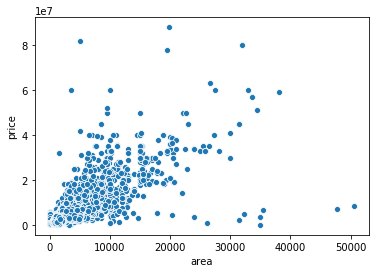

In [96]:
sns.scatterplot(data=df,x='area',y='price')

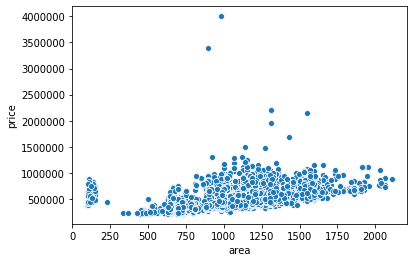

In [93]:
sns.scatterplot(data=hdb_df,x='area',y='price')

In [101]:
hdb_df[hdb_df.price>2e6]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price
17270,Singapore 650419 - D23,"High Floor,Stove,Bomb Shelter,Renovated,Aircon",893,2.0,3.0,"Exclusive 4S unit high floor for sale. \nNo odd shape \n\nWindy & bright unit. \nLarge size with only one neighbour beside u\nMaster bedroom with attached toilet \n\nEnjoy amenities such as shops, supermarkets and coffeeshop right at your doorstep. \nWide array of buses to get u to anywhere. Alternatively 12 mins walk to Bukit Gombak MRT. \n\nFor viewing pls call/text Irene @ 9631 7367 for appt","Availability,Now,District,D23",1986 -,https://www.99.co/singapore/sale/property/419-bukit-batok-west-avenue-2-hdb-JNhjFvHXLhqtETyMsrjSJG,419 Bukit Batok West Avenue 2,3400006.0,HDB 4 Rooms,3807
17805,Singapore 380016 - D14,NaN,1313,4.0,4.0,"PROFIT! PROFIT! PROFIT!\r\n\r\nGet 4% yield immediately. \r\nRenovated shophouse, residential above, commercial below. Lovely abode next to kallang river. Next Best riverside investment. \r\n\r\nCome view and have the foresight to see the potential as I walk you through the place. \r\n\r\n","Availability,Now,District,D14",1975 - 99 years,https://www.99.co/singapore/sale/property/16-upper-boon-keng-road-hdb-S4Q2Kfg8VzhmDoDvs6fX67,16 Upper Boon Keng Road,2200000.0,HDB,1676
17925,Singapore 380016 - D14,NaN,1313,4.0,4.0,"PROFIT! PROFIT! PROFIT!\r\n\r\nGet 4% yield immediately. \r\nRenovated shophouse, residential above, commercial below. Lovely abode next to kallang river. Next Best riverside investment. \r\n\r\nCome view and have the foresight to see the potential as I walk you through the place. \r\n\r\n","Availability,Now,District,D14",1975 - 99 years,https://www.99.co/singapore/sale/property/16-upper-boon-keng-road-hdb-6FEbR2LxYNZSF7g8SbzGpP,16 Upper Boon Keng Road,2200000.0,HDB,1676
18145,Singapore 380016 - D14,NaN,1313,4.0,4.0,"PROFIT! PROFIT! PROFIT!\r\n\r\nGet 4% yield immediately. \r\nRenovated shophouse, residential above, commercial below. Lovely abode next to kallang river. Next Best riverside investment. \r\n\r\nCome view and have the foresight to see the potential as I walk you through the place. \r\n\r\n","Availability,Now,District,D14",1975 - 99 years,https://www.99.co/singapore/sale/property/16-upper-boon-keng-road-hdb-iHn6Ah9SRKpPZSMR2RPKST,16 Upper Boon Keng Road,2200000.0,HDB,1676
18354,Singapore 380016 - D14,NaN,1313,4.0,4.0,"PROFIT! PROFIT! PROFIT!\r\n\r\nGet 4% yield immediately. \r\nRenovated shophouse, residential above, commercial below. Lovely abode next to kallang river. Next Best riverside investment. \r\n\r\nCome view and have the foresight to see the potential as I walk you through the place. \r\n\r\n","Availability,Now,District,D14",1975 - 99 years,https://www.99.co/singapore/sale/property/16-upper-boon-keng-road-hdb-3QJ8wUCkhVdjJQrn6B3sda,16 Upper Boon Keng Road,2200000.0,HDB,1676
19160,Singapore 820133 - D19,"High Floor,Renovated",980,2.0,3.0,"133 Edgedale Fields - 4 Room Flat for Sale\n\nHigh floor\nWindy\nUnblock \nMinutes Walk to Coral Edge LRT and 3 Stops to Punggol MRT\nNear to Punggol 21, Punggol Plaza and lots of amenities \nViewing by appointment \n\nPlease call Simmone 9146 2435 for viewing appointment","Facing,North South,Availability,Now,District,D19",2003 -,https://www.99.co/singapore/sale/property/133-edgedale-plains-hdb-69gk4Y4rN2Fm6xjUBY8EGV,133 Edgedale Plains,4000000.0,HDB 4 Rooms,4082
22366,Singapore 520268 - D18,NaN,1550,3.0,2.0,TAMPINES STREET 21,"District,D18",1984 -,https://www.99.co/singapore/sale/property/268-tampines-street-21-hdb-qD6qb9wRqaoHX7DwjKxrKo,268 Tampines Street 21,2150000.0,HDB 2 Rooms,1387
22937,Singapore 380016 - D14,NaN,1313,4.0,4.0,"PROFIT! PROFIT! PROFIT!\r\n\r\nGet 4% yield immediately. \r\nRenovated shophouse, residential above, commercial below. Lovely abode next to kallang river. Next Best riverside investment. \r\n\r\nCome view and have the foresight to see the potential as I walk you through the place. \r\n\r\n","Availability

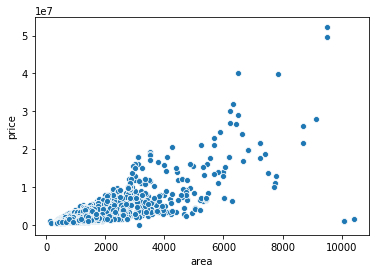

In [98]:
sns.scatterplot(data=condo_df,x='area',y='price')

### list of features to engineer

y = price

x = 
bedrooms
bathrooms
area
district
floor
lease remaining
flat age
distance from mrt
distance from lrt

In [36]:
df.head()

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price
0,12 Dairy Farm Lane - D23,"Function Room,Water Feature,High Ceiling,Gym,J...",624,2.0,2.0,DAIRY FARM RESIDENCES – BRIEF\nOur development...,"Facing,North South,District,D23",2024 - 99 years,https://www.99.co/singapore/sale/property/dair...,Dairy Farm Residences,969000.0,Condo,1553
1,2 Shunfu Road - D20,"Jogging Track,Games Room,Gym,Sea View,Steam Ro...",764,NaN,NaN,Jadescape (Former Shunfu Ville)\r\n\r\nJadesca...,"Furnishing,Unfurnished,Facing,North South,Avai...",2023 - 99 years,https://www.99.co/singapore/sale/property/jade...,JadeScape,1275408.0,Condo,1669
2,21 Marina Way - D1,"Clubhouse,Gym,City View,Jacuzzi,Outdoor Dining...",710,2.0,1.0,Prices dropped. Hurry! \nBrought to you by M+S...,"Facing,South West,Availability,Now,District,D01",2018 - 99 years,https://www.99.co/singapore/sale/property/mari...,Marina One Residences,1580000.0,Condo,2225
3,3 Jalan Kemaman - D12,"Clubhouse,Pool Deck,Sky Lounge,Gym,Tennis Cour...",441,1.0,1.0,VERTICUS – DISTRICT 12 – JALAN KEMAMAN\r\n\r\n...,"Furnishing,Unfurnished,Facing,North South,Avai...",- Freehold,https://www.99.co/singapore/sale/property/vert...,Verticus,889000.0,Condo,2016
4,5 Jalan Kemaman - D12,"Clubhouse,Bomb Shelter,Greenery View,Swimming ...",635,1.0,2.0,VERTICUS – FREEHOLD at DISTRICT 12 – JALAN KEM...,"Furnishing,Unfurnished,Availability,Now,Distri...",1993 - Freehold,https://www.99.co/singapore/sale/property/kema...,Kemaman Point,1244000.0,NaN,1959


In [86]:
hdb5rm_df = df[df.property_type=='HDB 5 Rooms']

In [88]:
hdb5rm_df['price'].mean()

609020.0426296866

In [97]:
import numpy as np
np.sqrt(hdb5rm_df['price'].apply(lambda x: (x-609020.0426296866)**2).mean())

162158.2628961796

In [48]:
df[df['property_type'].notnull()][df[df['property_type'].notnull()]['property_type'].str.contains('HDB')]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price,listing_id
16129,Singapore 543265 - D19,NaN,990 sqft / 91.97 sqm,2.0,3,Click link to view 360 House Video = http://bi...,"Furnishing,Partially Furnished,Availability,No...",2008 - 99 years,https://www.99.co/singapore/sale/property/265c...,265C Compassvale Link,"$570,000",HDB 4 Rooms,$576 psf,zScvBaMQDhzaQF7Y8bsMCh
16130,Singapore 160032 - D3,NaN,548 sqft / 50.91 sqm,1.0,2,Rare 2 Room Flat at Tiong Bahru MRT for Sale!!...,"Furnishing,Partially Furnished,Availability,No...",1971 -,https://www.99.co/singapore/sale/property/32-j...,32 Jalan Bukit Ho Swee,"$260,000",HDB 2 Rooms,$474 psf,mkJmVrRVTDnoMXiNDAoEAA
16131,Singapore 120306 - D5,"Greenery View,Renovated",721 sqft / 66.98 sqm,2.0,2,***New listing***\n\nHdb 3NG for sale\n\n* mid...,"Furnishing,Partially Furnished,Availability,No...",1979 - 99 years,https://www.99.co/singapore/sale/property/306-...,306 Clementi Avenue 4,"$299,000",HDB 3 Rooms,$415 psf,jAQxqtkSETKQWnbCMQnJQ4
16137,Singapore 821126 - D19,Bomb Shelter,"1,184 sqft / 109.99 sqm",3.0,2,Super Super Attractive Price!\nONLY $400K!\n5 ...,"Furnishing,Partially Furnished,Facing,South Ea...",2003 -,https://www.99.co/singapore/sale/property/126a...,126A Edgedale Plains,"$400,000",HDB 5 Rooms,$338 psf,aj5frZ7a5MnZBnFYmjCtj9
16138,Singapore 460406 - D16,"High Floor,City View,Sea View,Greenery View","1,270 sqft / 117.98 sqm",2.0,3,5RM/ 5I HDB @ Bedok North - For Sale\r\n======...,"Furnishing,Unfurnished,Facing,South,Availabili...",1980 - 99 years,https://www.99.co/singapore/sale/property/406-...,406 Bedok North Avenue 3,"$690,000",HDB 5 Rooms,$543 psf,aAtBqBCo4sog2WorA8i57U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24120,Singapore 530370 - D19,NaN,"1,087 sqft / 100.98 sqm",2.0,3,* Another Unit Brought to You by Evangeline * ...,"Availability,Now,District,D19",1999 -,https://www.99.co/singapore/sale/property/370-...,370 Hougang Street 31,"$458,000",HDB 4 Rooms,$421 psf,CjF49gZw7g7KX2YFufDtxB
24142,Singapore 123311 - D5,"Parking,Playground,Fitness Corner,Hydrotherapy...",861 sqft / 79.98 sqm,2.0,3,311C Clementi Avenue 4,"District,D05",2015 - 99 years,https://www.99.co/singapore/sale/property/311c...,311C Clementi Avenue 4,"$799,888",HDB 3 Rooms,$929 psf,33N7KxaHq2cpFkoK7hitjk
24143,Singapore 643654 - D22,NaN,"1,194 sqft / 110.92 sqm",2.0,3,654C JURONG WEST STREET 61\n------------------...,"Furnishing,Partially Furnished,District,D22",2002 -,https://www.99.co/singapore/sale/property/654c...,654C Jurong West Street 61,"$460,000",HDB 5 Rooms,$385 psf,9kPT6Hf3tuxkWyLf74ZSSD
24144,Singapore 794430 - D28,"High Floor,Corner Unit,Aircon","1,205 sqft / 111.94 sqm",2.0,3,Just MOP HDB 5 Room for Sale ....\n\nVery high...,"Furnishing,Partially Furnished,Availability,No...",2015 - 99 years,https://www.99.co/singapore/sale/property/430d...,430D Fernvale Link,"$600,000",HDB 5 Rooms,$498 psf,hHbWMBvJc9QwyYtQhz7YDL


In [38]:
df['bedrooms'].value_counts(dropna=False)

3      8468
2      3701
5      3568
4      3394
1      1618
NaN    1339
6      1252
7       429
8       157
10       84
0        75
9        58
         15
Name: bedrooms, dtype: int64

In [39]:
df['bathrooms'].value_counts(dropna=False)

2.0     10448
3.0      3025
1.0      2604
5.0      2178
4.0      2006
6.0      1501
NaN      1339
7.0       642
8.0       281
9.0       127
10.0        7
Name: bathrooms, dtype: int64

In [25]:
df['bedrooms'].unique()

array(['2', nan, '1', '3', '9', '4', '5', '6', '7', '8', '0', '10', ' '],
      dtype=object)

In [179]:
hdb_df

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,price,property_type,psf_price,district,floor_type
1256,Lilac Park - D28,Playground,2200,3.0,4.0,Lilac Park,NaN,1990 - Freehold,https://www.99.co/singapore/sale/property/property-in-singapore-landed-JkieMG5XD4hdbbCKHRZWb5,Lilac Park,3000000.0,Terraced House,1364,D28,NaN
8760,1 Keppel Bay View - D4,"Clubhouse,Bomb Shelter,Greenery View,Ground Floor,Swimming Pool,Jacuzzi,Playground,Patio / PES,Gym,BBQ,Tennis Court",1690,3.0,3.0,2 YEARS DEFERRED PAYMENT SCHEME IS BACK! ONLY FOR SELECTED VACANT UNITS!\r\n\r\nNEW STAR BUYS RELEASED! $180k ADDITIONAL DISCOUNT FROM PREVIOUS PRICE!\r\n\r\nReflections at Keppel Bay Relaunch\r\n\r\nSingapore's Most Iconic Waterfront Development\r\n\r\nMost Anticipated Blk 8 Villa is finally launching for sales!!! Don't Miss!\r\n\r\nBe the first to view these newly released premium villa units!\r\n\r\nNormal Payment Scheme with attractive Furniture Rebate!\r\n\r\nPriced to sell!\r\n\r\nAttractive price from $14XXpsf (cheaper than suburban prices)\r\n\r\nUnits with scenic views are available!\r\n\r\nCall Alfred @ 96428496 for exclusive viewing and more information now!\r\n\r\nAlfred Chee \r\nPropnex Appointed Tagger\r\n96428496\r\n\r\n#Reflectionsrelaunch\r\n#iconicwaterfrontdevelopment\r\n#KeppelBay\r\n#Bestinvestmentscheme\r\n#HighROI\r\n#Mustgrabopportunity\r\n#LuxuryProperty\r\n#PNG\r\n#PropnexUnited,"Furnishing,Partially Furnished,Availability,Now,District,D04",2011 - 99 years,https://www.99.co/singapore/sale/property/reflections-at-keppel-bay-condo-RfrkwmM6b9Mabsw2hJhdb6,Reflections At Keppel Bay,2888000.0,Condo,1709,D4,NaN
16129,Singapore 543265 - D19,NaN,990,2.0,3.0,Click link to view 360 House Video = http://bit.ly/265Ccompassvale\r\n\r\nBlock 265C Compassvale for Sale!!\r\nAddress = 265C Compassvale Link S(543265)\r\n4A Model\r\n3 Bedrooms\r\n2 Baths\r\nSize = 990sqft\r\nSuper High Floor\r\nCorner Unit\r\nFully Renovated\r\nExtremely Well Maintained by single lady owner\r\nUnblocked View\r\nCan only grant option after 11-Feb 2020\r\nBalance lease = 01-May 2008 (Balance est 87 years)\r\nMins walk to Buangkok MRT Station\r\nFuture shopping mall at MRT station\r\nPlenty of amenities\r\n\r\nPlease call/SMS Peter(ERA) 83838300 to arrange for viewing.,"Furnishing,Partially Furnished,Availability,Now,District,D19",2008 - 99 years,https://www.99.co/singapore/sale/property/265c-compassvale-link-hdb-zScvBaMQDhzaQF7Y8bsMCh,265C Compassvale Link,570000.0,HDB 4 Rooms,576,D19,NaN
16130,Singapore 160032 - D3,NaN,548,1.0,2.0,Rare 2 Room Flat at Tiong Bahru MRT for Sale!!\r\n\r\nBlock 32 Jalan Bukit Ho Swee\r\n2 room flat\r\n1 Bedroom\r\n1 Utility Room\r\n1 Bathroom\r\nSize = 548sf\r\nMid Floor\r\nLift Level\r\nNext to Corner \r\nUnblock Greenery View\r\nSimple Renovation\r\nQuiet Environment\r\nChinese race not eligible\r\nTOP = 01-Jan 1971 \r\nBalance around 50+ years lease\r\nStone throw away from Tiong Bahru MRT Station\r\nLess than 3 mins walk to Tiong Bahru Plaza\r\n\r\nPlease call/SMS Peter(ERA) 83838300 to arrange for viewing. \r\n\r\nAgents Welcome!,"Furnishing,Partially Furnished,Availability,Now,District,D03",1971 -,https://www.99.co/singapore/sale/property/32-jalan-bukit-ho-swee-hdb-mkJmVrRVTDnoMXiNDAoEAA,32 Jalan Bukit Ho Swee,260000.0,HDB 2 Rooms,474,D3,NaN
16131,Singapore 120306 - D5,"Greenery View,Renovated",721,2.0,2.0,***New listing***\n\nHdb 3NG for sale\n\n* mid floor\n* Good condition\n* Spacious layout\n* Good size bedroom\n* come with attached bathroom\n* fully fitted\n* nice and peaceful environment \n* quiet facing\n* walk to eateries and amenities \n* viewing flexible \n* mins drive to town \n* near public transportation and MRT \n\nLaven Loo\nPropNex Realty\n 65 9798 7489,"Furnishing,Partially Furnished,Availability,Now,District,D05",1979 - 99 years,https://www.99.co/singapore/sale/property/306-clementi-avenue-4-hdb-jAQxqtkSETKQWnbCMQnJQ4,306 Clementi Avenue 4,299000.0,HDB 3 Rooms,415,D5,NaN
...,...,...,...,.

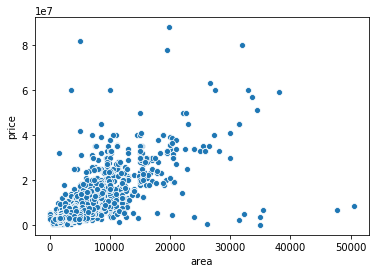

In [99]:
sns.scatterplot(data=landed_df,x='area',y='price')

### Linear Regression

In [211]:
lin_reg = LinearRegression()

In [213]:
hdb_df.columns

Index(['address', 'amenities', 'area', 'bathrooms', 'bedrooms', 'description',
       'details', 'lease', 'link', 'name', 'price', 'property_type',
       'psf_price', 'district', 'floor_type', 'floor', 'built_date',
       'lease_duration', 'full_address', 'latitude', 'longitude',
       'distance_to_station', 'nearest_station', 'nearest_station_type'],
      dtype='object')

In [275]:
hdb_district_dummies = pd.get_dummies(hdb_df['district'], prefix = 'district')
hdb_station_type_dummies = pd.get_dummies(hdb_df['nearest_station_type'], prefix = 'station_type')
hdb_model_df = pd.concat([hdb_df, hdb_district_dummies, hdb_station_type_dummies], axis=1)
hdb_model_df = hdb_model_df.drop(['address','amenities','description','details','lease','link','name','property_type','district','floor_type','floor','built_date','lease_duration','full_address','latitude','longitude','nearest_station','nearest_station_type'],axis=1)

In [276]:
hdb_model_df = hdb_model_df.dropna()

In [277]:
hdb_X_df = hdb_model_df.drop(['psf_price','price'],axis=1)
hdb_Y_df = hdb_model_df.price

In [278]:
lin_reg.fit(hdb_X_df,hdb_Y_df)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [279]:
hdb_Y_pred = lin_reg.predict(hdb_X_df)

In [219]:
from sklearn.metrics import mean_squared_error, r2_score

In [69]:
#baseline prediction:
hdb_Y_df.mean()

534139.8657887736

In [75]:
#baseline RMSE:
np.sqrt(hdb_Y_df.apply(lambda x: (x - hdb_Y_df.mean())**2).mean())

195707.87041036892

In [281]:
hdb_X_df.columns

Index(['area', 'bathrooms', 'bedrooms', 'distance_to_station', 'district_D1',
       'district_D10', 'district_D12', 'district_D13', 'district_D14',
       'district_D15', 'district_D16', 'district_D17', 'district_D18',
       'district_D19', 'district_D2', 'district_D20', 'district_D21',
       'district_D22', 'district_D23', 'district_D25', 'district_D27',
       'district_D28', 'district_D3', 'district_D4', 'district_D5',
       'district_D7', 'district_D8', 'station_type_LRT', 'station_type_MRT'],
      dtype='object')

In [280]:
# The coefficients
print('Coefficients: \n', lin_reg.coef_)
# The mean squared error
print('Root mean squared error: %.2f'
      % np.sqrt(mean_squared_error(hdb_Y_df, hdb_Y_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(hdb_Y_df, hdb_Y_pred))

Coefficients: 
 [ 2.64462710e+02  8.89483188e+04  6.23945981e+04 -4.32688442e+04
  1.20605948e+05  8.49008960e+04  7.61784788e+04  3.43753436e+04
  5.93584575e+04  9.96661529e+04  5.10203985e+02  1.40744702e+05
 -2.36917040e+04 -1.57772893e+04  3.62390643e+05  1.85644002e+04
  1.69222905e+05 -7.44126187e+04 -9.26576697e+04 -1.52438324e+05
 -8.04706786e+04 -4.47714031e+04  2.24937746e+05  9.48140173e+04
  9.29610532e+04  7.83808260e+04  1.11775616e+05 -2.16765106e+03
  2.16765106e+03]
Root mean squared error: 142753.48
Coefficient of determination: 0.47


In [ ]:
# previous score

Coefficients: 
 [ 2.62001522e+02  9.05736022e+04  6.23574579e+04  1.40345744e+05
  9.63857538e+04  8.09975271e+04  4.21257814e+04  6.70600402e+04
  1.09613503e+05  1.20604970e+03  1.87179380e+04 -2.61665070e+04
 -1.10519182e+04  3.66779244e+05  1.82887494e+04  1.79639711e+05
 -8.39260481e+04 -8.88936610e+04 -1.60463094e+05 -8.86108889e+04
 -3.35902721e+04  2.31824040e+05  8.76729122e+04  9.07164187e+04
  9.31274536e+04  1.23008955e+05]
Root mean squared error: 143435.30
Coefficient of determination: 0.46

In [241]:
hdb_X_df.columns

Index(['area', 'bathrooms', 'bedrooms', 'distance_to_station', 'district_D1',
       'district_D10', 'district_D12', 'district_D13', 'district_D14',
       'district_D15', 'district_D16', 'district_D17', 'district_D18',
       'district_D19', 'district_D2', 'district_D20', 'district_D21',
       'district_D22', 'district_D23', 'district_D25', 'district_D27',
       'district_D28', 'district_D3', 'district_D4', 'district_D5',
       'district_D7', 'district_D8'],
      dtype='object')

In [239]:
hdb_model_df.price.describe()

count    7.518000e+03
mean     5.341399e+05
std      1.957209e+05
min      2.180000e+05
25%      4.000000e+05
50%      5.000000e+05
75%      6.380000e+05
max      4.000000e+06
Name: price, dtype: float64

In [245]:
hdb_model_df[hdb_model_df.district_D12==1]

,area,bathrooms,bedrooms,price,psf_price,distance_to_station,district_D1,district_D10,district_D12,district_D13,...,district_D22,district_D23,district_D25,district_D27,district_D28,district_D3,district_D4,district_D5,district_D7,district_D8
16275,1259,2.0,3.0,610000.0,485,0.483231,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16276,1259,2.0,3.0,610000.0,485,0.483231,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16277,1259,2.0,3.0,610000.0,485,0.483231,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16278,1259,2.0,3.0,610000.0,485,0.483231,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16279,1259,2.0,3.0,610000.0,485,0.483231,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23812,830,1.0,2.0,325000.0,392,0.429136,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
23842,1302,2.0,3.0,650000.0,499,0.314439,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
23922,1129,2.0,3.0,720000.0,638,0.371862,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
23925,721,2.0,2.0,260000.0,361,0.745808,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [258]:
hdb_df[hdb_df.area<200]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,...,floor_type,floor,built_date,lease_duration,full_address,latitude,longitude,distance_to_station,nearest_station,nearest_station_type
16356,Singapore 611138,"High Floor,Bomb Shelter",105,2.0,3.0,"*Exclusive Listing*\nUnique security feature with Access Control to lift lobby only to residence. \n5-minute drive to AYE expressway.\nExclusively Rare Unit for investment and own staying\n5R DBSS Model\n*3 bed rooms + 2 bath rooms \n*Square living room and spacious layout.\n*Fully renovated and well maintained.\n*Nearest MRT: Lakeside MRT and Boon Lay MRT.\n*Proximity to many educational institutions such as:\nJurong Secondary School\nLakeside Primary School\nNational Technological University\n*Easy reach and Minutes’ walk to Superbowl Jurong, Jurong Lake Gardens, Taman Jurong Park, Taman Jurong Shopping Centre, Taman Jurong Market and Food Centre.\n*Unblock good view to vicinity.\nCall to view at 9765 2941","Availability,Now,Lease,Flexible",- 99 years,https://www.99.co/singapore/sale/property/138a-yuan-ching-road-hdb-i8HuwBFWkzCJRt7h6huvPa,138A Yuan Ching Road,...,NaN,None,,99 years,138A YUAN CHING ROAD LAKE VISTA @ YUAN CHING SINGAPORE 611138,1.327937,103.724178,1.844158,Lakeside,MRT
16598,Singapore 470769,"High Floor,Bomb Shelter,Corner Unit,Renovated",118,2.0,3.0,"769 Bedok Reservoir View living close to Reservoir Nature & Downtown MRT (Bedok Reservoir), 5I CORNER sitting on high floor. Living hall & Master partial canal view & Kitchen / Common Room unblock view. The entire house come with impressive functional layout of 115sqm & fully renovated, living hall / kitchen is rectangular shape and brightly lit and in all bedrooms too, allowing enough natural lightings into the unit and almost unblock, squarish layout in all bedrooms which is enough to put K'size bed in all bedroom and kitchen come with service yard for laundry. Renovation was done in 2011 (8 Years) with fully functional kitchen L-Shape top/bottom cabinet with built-in oven, stove and hood. Very well segregated layout for living and dining. Kitchen wall can be knocked down in the event you would like to have open concept kitchen. Master room & 1 Common Room come with a Built-in closet with plentiful of storage and drawer from floor to ceiling. Owner is a middle age chinese family, if you enjoy the serenity of the location yet is stone throw away to amenities (NTUC, coffeeshops, Mac, Guardians, Clinic, Hardware, Confectionery etc..).\n\n* 530m Away from Bedok Reservoir MRT (Downtown Line), 5-6 mins walk to MRT\n* 1.5km Away from Amenities (Blk 739-746 HDB Shophouses)\n* Within 1km Schools (Temasek Poly, Bedok Green Sec, Red Swastika Sch, Saint Anothony’s Canossian Sec)\n\n* HDB 5I Model\n* 1,237 Sqft / 115 Sqm\n* 3 Bedroom 2 Bathroom Service Yard Bomb Shelter\n* High Floor\n* CORNER (Corridor End Last Unit)\n* Impressive Layout (Regular & Squarish Layout)\n* Aircon (4 Split Unit) in all bedrooms & Living Hall\n* Well Kept Condition\n* Tastefully Renovated (8 Years Only)\n* Living with Homogeneous Tiles & All Bedrooms Parquet Flooring\n* Chinese House\n* TOP 2000 (19yo Flat / Balance 80 Years)\n* Serious Seller (Looking to Upgrade to 5 Room)\n\nInterested Cobroke Agent / Buyer:\nFor Quick Respond!\n\nPlease Call / SMS / WhatsApp Khayden @ 65 9423 0967 (Propnex) \nCEA Reg No: R015159B","Facing,North South,Availability,Now,District,D16",2000 - 99 years,https://www.99.co/singapore/sale/property/769-bedok-reservoir-view-hdb-yskfE6Gd7GPTfYL6ApX4c7,769 Bedok Reservoir View,...,NaN,None,2000,99 years,769 BEDOK RESERVOIR VIEW LONGVALE SINGAPORE 470769,1.335779,103.937912,0.546318,Bedok Reservoir,MRT
16599,Singapore 470769,"High Floor,Bomb Shelter,Corner Unit,Renovated",118,2.0,3.0,"769 Bedok Reservoir View living close to Reservoir Nature & Downtown MRT (Bedok Reservoir), 5I CORNER sitting on high floor. Living hall & Master partial canal view & Kitchen / Common Room unblock view. The entire house c

In [262]:
hdb_df[(hdb_df.psf_price>3000)&(hdb_df.area>200)]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,...,floor_type,floor,built_date,lease_duration,full_address,latitude,longitude,distance_to_station,nearest_station,nearest_station_type
19493,Singapore 650419,"High Floor,Stove,Bomb Shelter,Renovated,Aircon",893,2.0,3.0,"Exclusive 4S unit high floor for sale. \nNo odd shape \n\nWindy & bright unit. \nLarge size with only one neighbour beside u\nMaster bedroom with attached toilet \n\nEnjoy amenities such as shops, supermarkets and coffeeshop right at your doorstep. \nWide array of buses to get u to anywhere. Alternatively 12 mins walk to Bukit Gombak MRT. \n\nFor viewing pls call/text Irene @ 9631 7367 for appt","Availability,Now,District,D23",1986 -,https://www.99.co/singapore/sale/property/419-bukit-batok-west-avenue-2-hdb-JNhjFvHXLhqtETyMsrjSJG,419 Bukit Batok West Avenue 2,...,NaN,None,1986,,419 BUKIT BATOK WEST AVENUE 2 HDB-BUKIT BATOK SINGAPORE 650419,1.361947,103.746196,0.707692,Bukit Gombak,MRT
21780,Singapore 820133,"High Floor,Renovated",980,2.0,3.0,"133 Edgedale Fields - 4 Room Flat for Sale\n\nHigh floor\nWindy\nUnblock \nMinutes Walk to Coral Edge LRT and 3 Stops to Punggol MRT\nNear to Punggol 21, Punggol Plaza and lots of amenities \nViewing by appointment \n\nPlease call Simmone 9146 2435 for viewing appointment","Facing,North South,Availability,Now,District,D19",2003 -,https://www.99.co/singapore/sale/property/133-edgedale-plains-hdb-69gk4Y4rN2Fm6xjUBY8EGV,133 Edgedale Plains,...,NaN,None,2003,,133 EDGEDALE PLAINS HDB-PUNGGOL SINGAPORE 820133,1.392832,103.910620,0.254294,Coral Edge,LRT


In [285]:
hdb_df[hdb_df.distance_to_station>3.4]

,address,amenities,area,bathrooms,bedrooms,description,details,lease,link,name,...,floor_type,floor,built_date,lease_duration,full_address,latitude,longitude,distance_to_station,nearest_station,nearest_station_type
17741,Singapore 500004,NaN,721,1.0,2.0,Attention To all 1st Timer!\nThis unit is BELOW $250K after CPF HOUSING GRANT.\n\nResort Living Lifestyle!\nStaycation everyday.\n\nGrap this unique low rise HDB at Changi Village.\nYour backyard is the sea and the beach..\nGreat Nasi Lemak and many more good food within walking distance.\n\nCall Katherine Neo @ 90073137 for viewing.\nCan CONTRA\n,"Furnishing,Partially Furnished,Availability,Now,District,D17",1980 - 99 years,https://www.99.co/singapore/sale/property/4-changi-village-road-hdb-oXeFML49hWyQB4CSerUenA,4 Changi Village Road,...,NaN,None,1980,99 years,4 CHANGI VILLAGE ROAD HDB-CHANGI VILLAGE ROV SINGAPORE 500004,1.389096,103.987463,3.482140,Changi Airport,MRT
17742,Singapore 500004,Renovated,721,1.0,2.0,"Attention To All 1st Timer!\nThis unit is BELOW $250k after CPF family grant \n\n\nStaycation Everyday!\n\n2 mins walk to the SEA and the Beach.\nBest Nasi Lemak and many good food at nearby eateries.\n\nRenovated unit , windy.\n\nCan Contra.\nCall Katherine Neo @ 90073137 for viewing.\n","Furnishing,Partially Furnished,Availability,Now,District,D17",1980 - 99 years,https://www.99.co/singapore/sale/property/4-changi-village-road-hdb-8pzGRqvvY8oPM8QsX7aoCi,4 Changi Village Road,...,NaN,None,1980,99 years,4 CHANGI VILLAGE ROAD HDB-CHANGI VILLAGE ROV SINGAPORE 500004,1.389096,103.987463,3.482140,Changi Airport,MRT
23339,Singapore 500005,NaN,710,1.0,2.0,Rare 3 Room for sale 5 Changi village 3rd floor lift level \n\nResort living \n\nBus service 9/89/19/2/59/109\n\nwalking distance Changi beach wet market Hawkers center shop 711 24 hours \n\nEasy excess to Tampines/Pasir Ris Mrt white sand mall \n\nDon’t Miss call 91473018 \n\nYussaini Slp Scotia \n\nAssociate Director \n\nR011432H,"Furnishing,Unfurnished,District,D17",1981 - 99 years,https://www.99.co/singapore/sale/property/5-changi-village-road-hdb-LeoD7it6RooXfb3xGguHu,5 Changi Village Road,...,NaN,None,1981,99 years,5 CHANGI VILLAGE ROAD SINGAPORE 500005,1.388853,103.986846,3.458235,Changi Airport,MRT


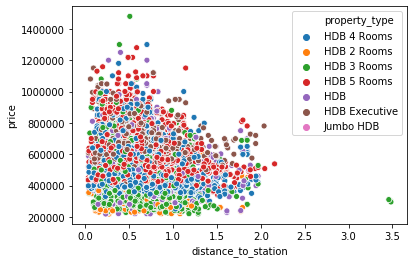

In [283]:
sns.scatterplot(x='distance_to_station',y='price',data=hdb_df[(hdb_df.area>200)&(hdb_df.psf_price<2500)&(hdb_df.price<1.5e6)], hue='property_type')

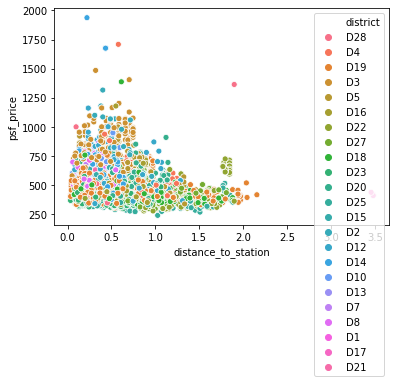

In [264]:
sns.scatterplot(x='distance_to_station',y='psf_price',data=hdb_df[(hdb_df.area>200)&(hdb_df.psf_price<2500)], hue='district')

In [ ]:
# print(__doc__)


# # Code source: Jaques Grobler
# # License: BSD 3 clause


# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import datasets, linear_model
# from sklearn.metrics import mean_squared_error, r2_score

# # Load the diabetes dataset
# diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# # Use only one feature
# diabetes_X = diabetes_X[:, np.newaxis, 2]

# # Split the data into training/testing sets
# diabetes_X_train = diabetes_X[:-20]
# diabetes_X_test = diabetes_X[-20:]

# # Split the targets into training/testing sets
# diabetes_y_train = diabetes_y[:-20]
# diabetes_y_test = diabetes_y[-20:]

# # Create linear regression object
# regr = linear_model.LinearRegression()

# # Train the model using the training sets
# regr.fit(diabetes_X_train, diabetes_y_train)

# # Make predictions using the testing set
# diabetes_y_pred = regr.predict(diabetes_X_test)

# # The coefficients
# print('Coefficients: \n', regr.coef_)
# # The mean squared error
# print('Mean squared error: %.2f'
#       % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.2f'
#       % r2_score(diabetes_y_test, diabetes_y_pred))

# # Plot outputs
# plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
# plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()